# Import Libraries

In [ ]:
# For drive access
from google.colab import drive
drive.mount('/content/drive')

# Standard libraries
import numpy as np
import pandas as pd

# for loading the pickle files with features and labels
import pickle

# For audio
from IPython.display import Audio
import librosa

# For preprocessing
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

# For modeling
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive


# Load features and labels from train and val pickle

In [ ]:
with open('/content/drive/MyDrive/project/train_val_features_pkl/train_val_5_sec_audio_features_avgpooled.pkl', 'rb') as file:
  audio_df = pickle.load(file)

In [ ]:
audio_df

{'train': {'mfcc': array([[0.3391694 , 0.40924874, 0.5358972 , ..., 0.54475796, 0.50564116,
          0.46894422],
         [0.33568618, 0.41750646, 0.53681815, ..., 0.542808  , 0.5288323 ,
          0.45956683],
         [0.36065662, 0.41422567, 0.5833725 , ..., 0.52050847, 0.55034566,
          0.44331655],
         ...,
         [0.59729165, 0.4938564 , 0.38847885, ..., 0.4174044 , 0.4665348 ,
          0.39914683],
         [0.6012123 , 0.51702017, 0.3863889 , ..., 0.42538506, 0.46877104,
          0.41223076],
         [0.6082435 , 0.5434134 , 0.37211478, ..., 0.4219473 , 0.46813804,
          0.40352035]], dtype=float32),
  'chroma': array([[0.3414871 , 0.35261095, 0.38855013, ..., 0.37608668, 0.36091387,
          0.37655085],
         [0.39570332, 0.35266703, 0.3601897 , ..., 0.3406976 , 0.36317727,
          0.4071223 ],
         [0.44144076, 0.37290844, 0.3611199 , ..., 0.27120224, 0.36760825,
          0.40015313],
         ...,
         [0.5226286 , 0.5496563 , 0.5463212 , 

In [ ]:
with open('/content/drive/MyDrive/project/train_val_features_pkl/train_val_5_sec_non_audio_features.pkl', 'rb') as file:
  non_audio_df = pickle.load(file)

In [ ]:
non_audio_df

{'train': {'type': array(['call', 'call', 'call', ..., 'call', 'call', 'call'], dtype='<U5'),
  'continent': array(['EUROPE', 'EUROPE', 'EUROPE', ..., 'EUROPE', 'EUROPE', 'EUROPE'],
        dtype='<U8'),
  'rating': array([5. , 5. , 5. , ..., 3.5, 3.5, 3.5]),
  'label': array([2, 2, 2, ..., 2, 2, 2])},
 'val': {'type': array(['call', 'call', 'call', ..., 'call', 'call', 'call'], dtype='<U5'),
  'continent': array(['EUROPE', 'EUROPE', 'EUROPE', ..., 'EUROPE', 'EUROPE', 'EUROPE'],
        dtype='<U8'),
  'rating': array([4. , 4. , 4. , ..., 2.5, 2.5, 2.5]),
  'label': array([1, 1, 1, ..., 1, 1, 1])}}

## confirm the audio features and non_audio features labels line-up

In [ ]:
assert np.array_equal(audio_df['train']['label'], non_audio_df['train']['label'])

In [ ]:
assert np.array_equal(audio_df['val']['label'], non_audio_df['val']['label'])

# Shuffle the data

In [ ]:
def shuffle_data(audio_features, non_audio_features):
  input_len = len(audio_features['label'])
  input_indices = np.random.permutation(input_len)
  audio_features = {key: np.array([audio_features[key][i] for i in input_indices]) for key in audio_features}
  non_audio_features = {key: np.array([non_audio_features[key][i] for i in input_indices]) for key in non_audio_features}

  return audio_features, non_audio_features

In [ ]:
audio_df['train'], non_audio_df['train'] = shuffle_data(audio_df['train'], non_audio_df['train'])

In [ ]:
for key in audio_df['train'].keys():
  display(key)
  display(audio_df['train'][key].shape)
  display(audio_df['train'][key][:5])

'mfcc'

(8236, 20)

array([[0.6599398 , 0.67788196, 0.5916634 , 0.66163284, 0.6008466 ,
        0.65279627, 0.6708636 , 0.5714917 , 0.68365616, 0.5804081 ,
        0.5984512 , 0.6284845 , 0.56266534, 0.6052219 , 0.56961256,
        0.52568096, 0.55559003, 0.5377412 , 0.5535624 , 0.5140197 ],
       [0.54474825, 0.31021774, 0.40692937, 0.5802146 , 0.38140574,
        0.39839464, 0.5134693 , 0.39821178, 0.45090568, 0.4708782 ,
        0.42730072, 0.4551945 , 0.4662672 , 0.47554442, 0.4132376 ,
        0.480067  , 0.50880855, 0.44871235, 0.5987532 , 0.43495765],
       [0.7466248 , 0.49147087, 0.51950824, 0.54424995, 0.54692084,
        0.49543262, 0.5410624 , 0.49458292, 0.5041331 , 0.48668647,
        0.53768635, 0.5777628 , 0.48602998, 0.5559642 , 0.47704247,
        0.5149159 , 0.47281584, 0.46078205, 0.5076168 , 0.43034962],
       [0.62033   , 0.72429127, 0.628927  , 0.6071583 , 0.653186  ,
        0.5030413 , 0.65818185, 0.5160119 , 0.5813763 , 0.49997586,
        0.5275559 , 0.516808  , 0.49097613, 0

'chroma'

(8236, 12)

array([[0.5443693 , 0.65482455, 0.78361344, 0.82185686, 0.78753597,
        0.64611936, 0.6182299 , 0.5452187 , 0.45511025, 0.4059525 ,
        0.4374207 , 0.4954643 ],
       [0.36578906, 0.30307755, 0.2716894 , 0.26682383, 0.4043773 ,
        0.60519135, 0.47652182, 0.29689863, 0.1978842 , 0.2900794 ,
        0.45217955, 0.34645888],
       [0.66759825, 0.47062382, 0.42182192, 0.48079517, 0.4113224 ,
        0.40746328, 0.3899399 , 0.39377254, 0.40552244, 0.39935866,
        0.4376189 , 0.6003393 ],
       [0.6094814 , 0.6049496 , 0.62642807, 0.61896306, 0.56617373,
        0.5966144 , 0.5981498 , 0.5960408 , 0.6039243 , 0.6113066 ,
        0.6302494 , 0.6276345 ],
       [0.26647905, 0.3170529 , 0.3668991 , 0.4403914 , 0.44294924,
        0.2958462 , 0.2904277 , 0.25654364, 0.44251874, 0.3209204 ,
        0.28362873, 0.29241043]], dtype=float32)

'rms'

(8236, 1)

array([[0.07944974],
       [0.02735221],
       [0.0467274 ],
       [0.02751585],
       [0.02581807]], dtype=float32)

'spectral_centroid'

(8236, 1)

array([[0.18257274],
       [0.5580287 ],
       [0.5518772 ],
       [0.17311078],
       [0.389458  ]], dtype=float32)

'melspectrogram'

(8236, 20)

array([[0.8243726 , 0.67964154, 0.62437314, 0.62339795, 0.6332726 ,
        0.6340325 , 0.63073826, 0.6185194 , 0.62037516, 0.61837596,
        0.59766483, 0.5860012 , 0.5555527 , 0.556081  , 0.5581838 ,
        0.5503735 , 0.5179709 , 0.4699723 , 0.44700584, 0.40826425],
       [0.31649908, 0.3279071 , 0.3359106 , 0.3666345 , 0.40404928,
        0.4294142 , 0.4520492 , 0.46833062, 0.49858293, 0.53698915,
        0.5534613 , 0.6024453 , 0.64630973, 0.6901458 , 0.64654815,
        0.6491898 , 0.616084  , 0.5751411 , 0.5489047 , 0.481385  ],
       [0.63880485, 0.5984165 , 0.6214866 , 0.6389957 , 0.63816833,
        0.66177577, 0.6788653 , 0.6975989 , 0.7047737 , 0.7110004 ,
        0.72027457, 0.7339221 , 0.70142424, 0.68983173, 0.66726625,
        0.68534714, 0.6796416 , 0.6475773 , 0.6526962 , 0.6244075 ],
       [0.76764584, 0.71427906, 0.65447986, 0.62861544, 0.6290218 ,
        0.62130594, 0.60589486, 0.5875937 , 0.57701665, 0.5707237 ,
        0.55255973, 0.5433575 , 0.50756043, 0

'label'

(8236,)

array([0, 0, 2, 0, 1])

In [ ]:
for key in non_audio_df['train'].keys():
  display(key)
  display(non_audio_df['train'][key].shape)
  display(non_audio_df['train'][key][:5])

'type'

(8236,)

array(['both', 'song', 'song', 'call', 'call'], dtype='<U5')

'continent'

(8236,)

array(['EUROPE', 'AMERICAS', 'EUROPE', 'EUROPE', 'EUROPE'], dtype='<U8')

'rating'

(8236,)

array([5. , 4.5, 5. , 3. , 5. ])

'label'

(8236,)

array([0, 0, 2, 0, 1])

In [ ]:
audio_df['val'], non_audio_df['val'] = shuffle_data(audio_df['val'], non_audio_df['val'])

In [ ]:
for key in audio_df['val'].keys():
  display(key)
  display(audio_df['val'][key].shape)
  display(audio_df['val'][key][:5])

'mfcc'

(4236, 20)

array([[0.76568013, 0.57164913, 0.46456724, 0.5092214 , 0.5086432 ,
        0.375803  , 0.49313924, 0.42147595, 0.45144975, 0.43413183,
        0.43369302, 0.48815224, 0.40844142, 0.5015402 , 0.43157396,
        0.4348336 , 0.53272897, 0.50046575, 0.45881307, 0.40277624],
       [0.48107755, 0.44918987, 0.60531807, 0.72855365, 0.6099299 ,
        0.5771958 , 0.61740327, 0.47882205, 0.54144025, 0.601868  ,
        0.518007  , 0.55390954, 0.5891538 , 0.60094196, 0.4649838 ,
        0.55285996, 0.5764328 , 0.5817557 , 0.55558765, 0.46817103],
       [0.5220496 , 0.42991617, 0.4323247 , 0.50297856, 0.67173594,
        0.7206725 , 0.77408254, 0.6301314 , 0.5874495 , 0.4697445 ,
        0.5650389 , 0.5027943 , 0.5774206 , 0.5107694 , 0.53791726,
        0.48808596, 0.46119544, 0.51717675, 0.44975957, 0.51023674],
       [0.46226546, 0.54370785, 0.5329523 , 0.44436976, 0.5802166 ,
        0.412908  , 0.39277554, 0.24611549, 0.36092135, 0.41200304,
        0.4215978 , 0.28404313, 0.30187613, 0

'chroma'

(4236, 12)

array([[0.5751129 , 0.67844445, 0.6358679 , 0.5706033 , 0.5290377 ,
        0.47302255, 0.59463274, 0.7009496 , 0.6832745 , 0.68654543,
        0.53037053, 0.55995166],
       [0.3969723 , 0.40799066, 0.389791  , 0.4777262 , 0.6120983 ,
        0.6702893 , 0.60694176, 0.58287954, 0.4950489 , 0.41521764,
        0.41251028, 0.42443395],
       [0.42973897, 0.5682909 , 0.7992822 , 0.7879919 , 0.45046744,
        0.382638  , 0.37767917, 0.37135634, 0.35418564, 0.38761166,
        0.41776043, 0.38158906],
       [0.15377554, 0.22899987, 0.3494523 , 0.52640635, 0.7830554 ,
        0.81317747, 0.64642847, 0.4138868 , 0.34484866, 0.2990851 ,
        0.2667633 , 0.21605107],
       [0.5070358 , 0.5869676 , 0.5993467 , 0.70593256, 0.6715506 ,
        0.53625727, 0.4521815 , 0.4826895 , 0.45558104, 0.44579756,
        0.4389798 , 0.43623868]], dtype=float32)

'rms'

(4236, 1)

array([[0.03714661],
       [0.0114965 ],
       [0.00733309],
       [0.00224914],
       [0.00193403]], dtype=float32)

'spectral_centroid'

(4236, 1)

array([[0.4149493 ],
       [0.54003876],
       [0.5523133 ],
       [0.49667937],
       [0.5380456 ]], dtype=float32)

'melspectrogram'

(4236, 20)

array([[0.64931566, 0.6859798 , 0.7082681 , 0.7106268 , 0.7315863 ,
        0.74317306, 0.73706585, 0.7481226 , 0.73979795, 0.76702756,
        0.7433123 , 0.75334805, 0.7212113 , 0.68455637, 0.6605433 ,
        0.6371918 , 0.61557114, 0.5941736 , 0.59718204, 0.56408864],
       [0.55238986, 0.41732618, 0.3797185 , 0.34054875, 0.32214126,
        0.3163941 , 0.34113064, 0.37083337, 0.40061125, 0.45270044,
        0.4420778 , 0.46510193, 0.51012117, 0.54376704, 0.51430976,
        0.50278205, 0.49956992, 0.46446967, 0.45182937, 0.4139909 ],
       [0.5045034 , 0.36111075, 0.26215607, 0.2731291 , 0.3652685 ,
        0.4861786 , 0.5455024 , 0.56285506, 0.56020343, 0.5548043 ,
        0.54418916, 0.5462747 , 0.5180996 , 0.5038181 , 0.48531064,
        0.48503628, 0.53121006, 0.51315105, 0.44886944, 0.4568664 ],
       [0.47579265, 0.4826052 , 0.47856155, 0.4359433 , 0.42305386,
        0.42717713, 0.40996367, 0.482699  , 0.53596175, 0.49855602,
        0.43067008, 0.41138366, 0.3976546 , 0

'label'

(4236,)

array([0, 0, 1, 1, 0])

In [ ]:
for key in non_audio_df['val'].keys():
  display(key)
  display(non_audio_df['val'][key].shape)
  display(non_audio_df['val'][key][:5])

'type'

(4236,)

array(['song', 'song', 'call', 'blank', 'call'], dtype='<U5')

'continent'

(4236,)

array(['ASIA', 'AMERICAS', 'EUROPE', 'EUROPE', 'EUROPE'], dtype='<U8')

'rating'

(4236,)

array([5. , 4.5, 4. , 4. , 5. ])

'label'

(4236,)

array([0, 0, 1, 1, 0])

# One Hot Encode Continents

In [ ]:
encoder = OneHotEncoder(sparse_output=False)

train_continents = non_audio_df['train']['continent'].reshape(-1, 1)
val_continents = non_audio_df['val']['continent'].reshape(-1, 1)

non_audio_df['train']['continent'] = encoder.fit_transform(train_continents)
non_audio_df['val']['continent'] = encoder.fit_transform(val_continents)

In [ ]:
display(non_audio_df['train']['continent'].shape)
display(non_audio_df['train']['continent'][:5])

display(non_audio_df['val']['continent'].shape)
display(non_audio_df['val']['continent'][:5])

(8236, 5)

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

(4236, 5)

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

# SVM Models

In [ ]:
train_results = {}
val_results = {}

In [ ]:
classes = ['barswa', 'comsan', 'eaywag1']

## With all features

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['chroma'], audio_df['train']['rms'], audio_df['train']['spectral_centroid'], audio_df['train']['melspectrogram'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.65993983, 0.67788196, 0.59166342, ..., 0.        , 1.        ,
        0.        ],
       [0.54474825, 0.31021774, 0.40692937, ..., 0.        , 0.        ,
        0.        ],
       [0.74662483, 0.49147087, 0.51950824, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.60939181, 0.67104828, 0.61745954, ..., 0.        , 1.        ,
        0.        ],
       [0.67268836, 0.64540893, 0.57666099, ..., 0.        , 1.        ,
        0.        ],
       [0.44762298, 0.71293002, 0.66515446, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
training_features.shape

(8236, 59)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['chroma'], audio_df['val']['rms'], audio_df['val']['spectral_centroid'], audio_df['val']['melspectrogram'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.76568013, 0.57164913, 0.46456724, ..., 1.        , 0.        ,
        0.        ],
       [0.48107755, 0.44918987, 0.60531807, ..., 0.        , 0.        ,
        0.        ],
       [0.52204961, 0.42991617, 0.43232471, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.5756709 , 0.46205077, 0.48502749, ..., 0.        , 1.        ,
        0.        ],
       [0.72670257, 0.6311999 , 0.46390355, ..., 0.        , 1.        ,
        0.        ],
       [0.53965062, 0.4281005 , 0.3346228 , ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(4236, 59)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['all_features'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['all_features'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.9233851384167071
Validation accuracy: 0.7247403210576016


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.94      0.90      0.92      2758
      comsan       0.95      0.93      0.94      2730
     eaywag1       0.88      0.94      0.91      2748

    accuracy                           0.92      8236
   macro avg       0.92      0.92      0.92      8236
weighted avg       0.92      0.92      0.92      8236



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.83      0.68      0.75      1760
      comsan       0.66      0.75      0.70      1112
     eaywag1       0.67      0.76      0.71      1364

    accuracy                           0.72      4236
   macro avg       0.72      0.73      0.72      4236
weighted avg       0.74      0.72      0.73      4236



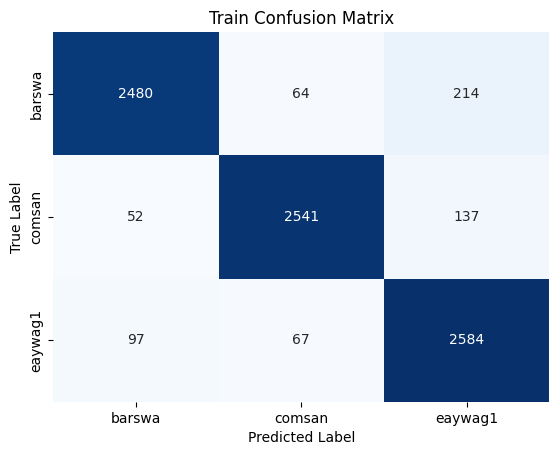

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

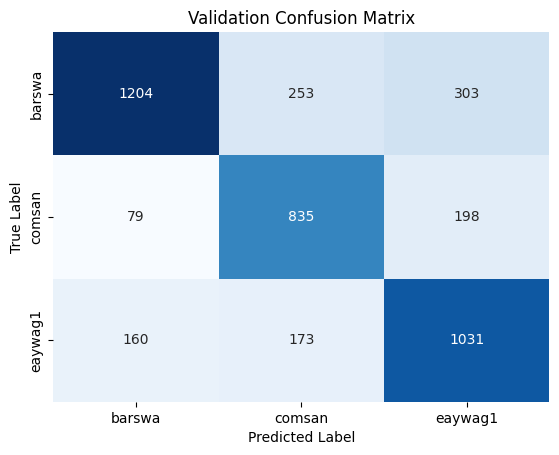

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With only MFCC

### create features

In [ ]:
training_features = audio_df['train']['mfcc']

training_features

array([[0.6599398 , 0.67788196, 0.5916634 , ..., 0.5377412 , 0.5535624 ,
        0.5140197 ],
       [0.54474825, 0.31021774, 0.40692937, ..., 0.44871235, 0.5987532 ,
        0.43495765],
       [0.7466248 , 0.49147087, 0.51950824, ..., 0.46078205, 0.5076168 ,
        0.43034962],
       ...,
       [0.6093918 , 0.6710483 , 0.61745954, ..., 0.49656445, 0.5148995 ,
        0.4895677 ],
       [0.67268836, 0.6454089 , 0.576661  , ..., 0.35545486, 0.39074603,
        0.33752975],
       [0.44762298, 0.71293   , 0.66515446, ..., 0.5276726 , 0.56250185,
        0.5489154 ]], dtype=float32)

In [ ]:
training_features.shape

(8236, 20)

In [ ]:
validation_features = audio_df['val']['mfcc']

validation_features

array([[0.76568013, 0.57164913, 0.46456724, ..., 0.50046575, 0.45881307,
        0.40277624],
       [0.48107755, 0.44918987, 0.60531807, ..., 0.5817557 , 0.55558765,
        0.46817103],
       [0.5220496 , 0.42991617, 0.4323247 , ..., 0.51717675, 0.44975957,
        0.51023674],
       ...,
       [0.5756709 , 0.46205077, 0.4850275 , ..., 0.52146083, 0.5784169 ,
        0.5162465 ],
       [0.7267026 , 0.6311999 , 0.46390355, ..., 0.5281577 , 0.54296   ,
        0.5004192 ],
       [0.5396506 , 0.4281005 , 0.3346228 , ..., 0.4724107 , 0.49113405,
        0.50845426]], dtype=float32)

In [ ]:
validation_features.shape

(4236, 20)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['mfcc'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['mfcc'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.9598105876639145
Validation accuracy: 0.6522662889518414


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.95      0.96      0.96      2758
      comsan       0.98      0.96      0.97      2730
     eaywag1       0.95      0.96      0.95      2748

    accuracy                           0.96      8236
   macro avg       0.96      0.96      0.96      8236
weighted avg       0.96      0.96      0.96      8236



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.72      0.62      0.66      1760
      comsan       0.60      0.75      0.67      1112
     eaywag1       0.63      0.62      0.62      1364

    accuracy                           0.65      4236
   macro avg       0.65      0.66      0.65      4236
weighted avg       0.66      0.65      0.65      4236



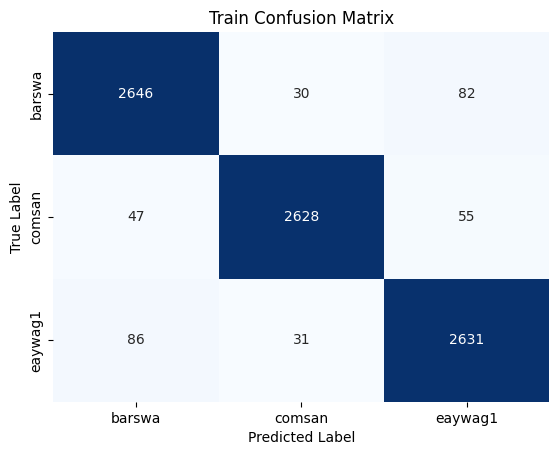

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

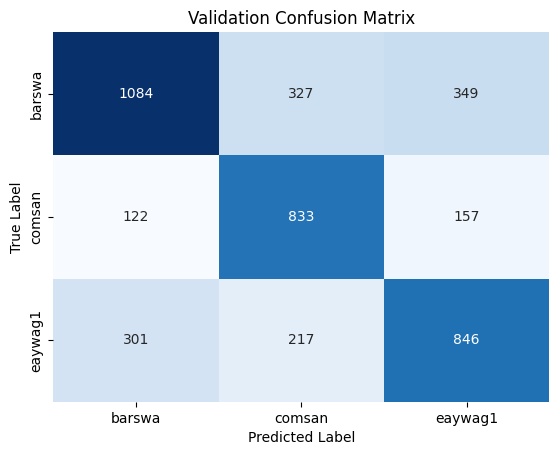

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With only chroma

### create features

In [ ]:
training_features = audio_df['train']['chroma']

training_features

array([[0.5443693 , 0.65482455, 0.78361344, ..., 0.4059525 , 0.4374207 ,
        0.4954643 ],
       [0.36578906, 0.30307755, 0.2716894 , ..., 0.2900794 , 0.45217955,
        0.34645888],
       [0.66759825, 0.47062382, 0.42182192, ..., 0.39935866, 0.4376189 ,
        0.6003393 ],
       ...,
       [0.34567606, 0.29807025, 0.4022064 , ..., 0.31887493, 0.31697342,
        0.38165548],
       [0.7269037 , 0.7317413 , 0.72624624, ..., 0.6198623 , 0.6679676 ,
        0.7234871 ],
       [0.62975514, 0.62226194, 0.6457521 , ..., 0.7246826 , 0.69019556,
        0.674213  ]], dtype=float32)

In [ ]:
training_features.shape

(8236, 12)

In [ ]:
validation_features = audio_df['val']['chroma']

validation_features

array([[0.5751129 , 0.67844445, 0.6358679 , ..., 0.68654543, 0.53037053,
        0.55995166],
       [0.3969723 , 0.40799066, 0.389791  , ..., 0.41521764, 0.41251028,
        0.42443395],
       [0.42973897, 0.5682909 , 0.7992822 , ..., 0.38761166, 0.41776043,
        0.38158906],
       ...,
       [0.51727754, 0.5258308 , 0.57746655, ..., 0.65162444, 0.6062873 ,
        0.5246389 ],
       [0.66837126, 0.6933629 , 0.7301517 , ..., 0.68770427, 0.6747188 ,
        0.6681061 ],
       [0.30965844, 0.34755647, 0.37105405, ..., 0.34563476, 0.37817886,
        0.35873854]], dtype=float32)

In [ ]:
validation_features.shape

(4236, 12)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['chroma'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['chroma'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.71369596891695
Validation accuracy: 0.5198300283286119


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.72      0.64      0.68      2758
      comsan       0.78      0.77      0.77      2730
     eaywag1       0.65      0.73      0.69      2748

    accuracy                           0.71      8236
   macro avg       0.72      0.71      0.71      8236
weighted avg       0.72      0.71      0.71      8236



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.58      0.42      0.49      1760
      comsan       0.51      0.61      0.56      1112
     eaywag1       0.48      0.58      0.52      1364

    accuracy                           0.52      4236
   macro avg       0.52      0.53      0.52      4236
weighted avg       0.53      0.52      0.52      4236



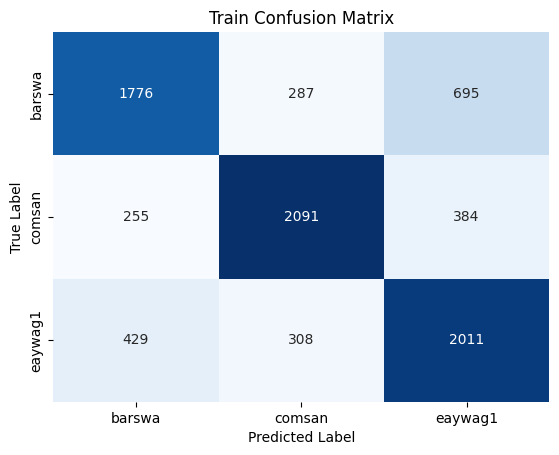

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

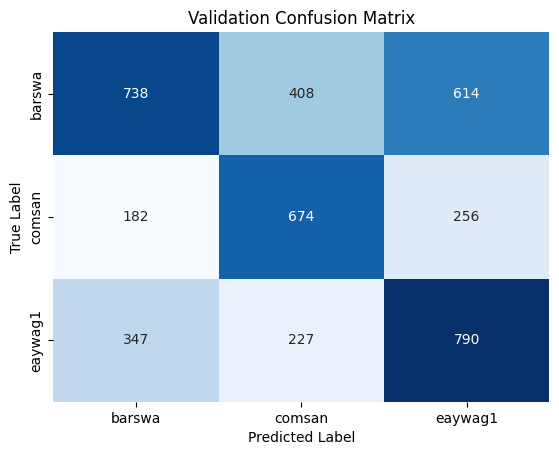

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With only RMS & Spectral_Centroid

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['rms'], audio_df['train']['spectral_centroid']), axis=1)

training_features

array([[0.07944974, 0.18257274],
       [0.02735221, 0.5580287 ],
       [0.0467274 , 0.5518772 ],
       ...,
       [0.01671822, 0.25034085],
       [0.01731251, 0.31776923],
       [0.00727899, 0.15188685]], dtype=float32)

In [ ]:
training_features.shape

(8236, 2)

In [ ]:
validation_features = np.concatenate((audio_df['val']['rms'], audio_df['val']['spectral_centroid']), axis=1)

validation_features

array([[0.03714661, 0.4149493 ],
       [0.0114965 , 0.54003876],
       [0.00733309, 0.5523133 ],
       ...,
       [0.03266476, 0.56785625],
       [0.02468226, 0.33517313],
       [0.01352605, 0.5132443 ]], dtype=float32)

In [ ]:
validation_features.shape

(4236, 2)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['rms_spectral_centroid'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['rms_spectral_centroid'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.46515298688683826
Validation accuracy: 0.38172804532577903


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.53      0.28      0.37      2758
      comsan       0.47      0.49      0.48      2730
     eaywag1       0.43      0.62      0.51      2748

    accuracy                           0.47      8236
   macro avg       0.48      0.47      0.45      8236
weighted avg       0.48      0.47      0.45      8236



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.76      0.20      0.31      1760
      comsan       0.36      0.62      0.46      1112
     eaywag1       0.31      0.42      0.36      1364

    accuracy                           0.38      4236
   macro avg       0.48      0.41      0.38      4236
weighted avg       0.51      0.38      0.37      4236



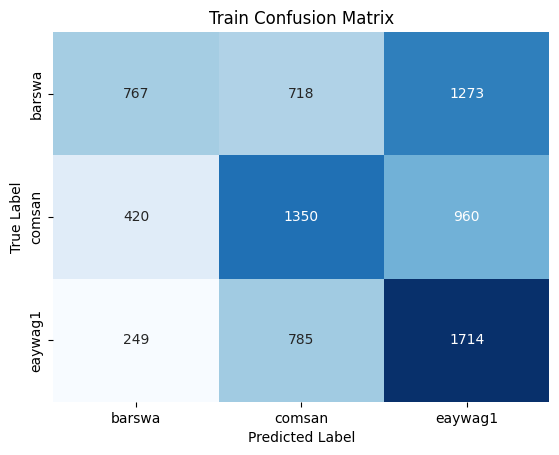

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

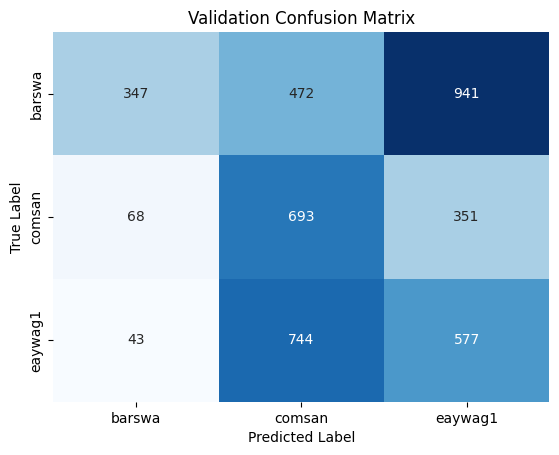

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With only melspectrogram

### create features

In [ ]:
training_features = audio_df['train']['melspectrogram']

training_features

array([[0.8243726 , 0.67964154, 0.62437314, ..., 0.4699723 , 0.44700584,
        0.40826425],
       [0.31649908, 0.3279071 , 0.3359106 , ..., 0.5751411 , 0.5489047 ,
        0.481385  ],
       [0.63880485, 0.5984165 , 0.6214866 , ..., 0.6475773 , 0.6526962 ,
        0.6244075 ],
       ...,
       [0.70898753, 0.6645553 , 0.6461834 , ..., 0.4176413 , 0.41985524,
        0.41585457],
       [0.72381747, 0.7159557 , 0.69224507, ..., 0.4855786 , 0.47938606,
        0.47216552],
       [0.6733246 , 0.5939276 , 0.50325996, ..., 0.26931545, 0.26497933,
        0.25809813]], dtype=float32)

In [ ]:
training_features.shape

(8236, 20)

In [ ]:
validation_features = audio_df['val']['melspectrogram']

validation_features

array([[0.64931566, 0.6859798 , 0.7082681 , ..., 0.5941736 , 0.59718204,
        0.56408864],
       [0.55238986, 0.41732618, 0.3797185 , ..., 0.46446967, 0.45182937,
        0.4139909 ],
       [0.5045034 , 0.36111075, 0.26215607, ..., 0.51315105, 0.44886944,
        0.4568664 ],
       ...,
       [0.4397016 , 0.4179946 , 0.4642485 , ..., 0.5406728 , 0.5353374 ,
        0.49378058],
       [0.6575653 , 0.6613865 , 0.681567  , ..., 0.50941664, 0.5057366 ,
        0.4927722 ],
       [0.31623325, 0.33782125, 0.35986283, ..., 0.5409326 , 0.45661458,
        0.44077992]], dtype=float32)

In [ ]:
validation_features.shape

(4236, 20)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['melspectrogram'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['melspectrogram'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.8614618746964546
Validation accuracy: 0.5767233238904627


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.89      0.86      0.87      2758
      comsan       0.91      0.85      0.88      2730
     eaywag1       0.79      0.87      0.83      2748

    accuracy                           0.86      8236
   macro avg       0.87      0.86      0.86      8236
weighted avg       0.87      0.86      0.86      8236



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.68      0.57      0.62      1760
      comsan       0.56      0.61      0.59      1112
     eaywag1       0.48      0.55      0.52      1364

    accuracy                           0.58      4236
   macro avg       0.58      0.58      0.58      4236
weighted avg       0.59      0.58      0.58      4236



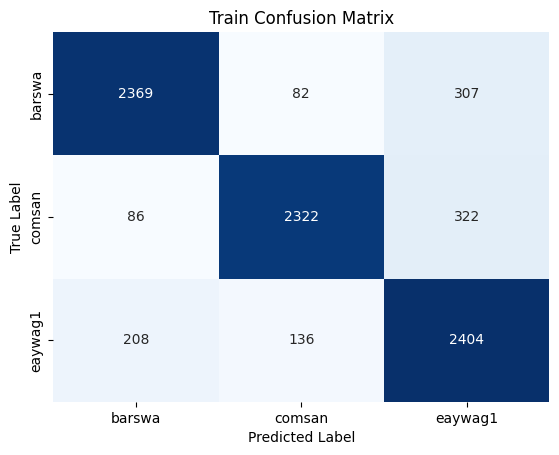

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

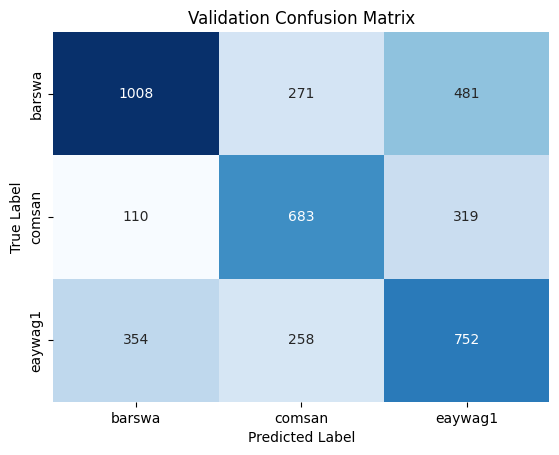

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.65993983, 0.67788196, 0.59166342, ..., 0.        , 1.        ,
        0.        ],
       [0.54474825, 0.31021774, 0.40692937, ..., 0.        , 0.        ,
        0.        ],
       [0.74662483, 0.49147087, 0.51950824, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.60939181, 0.67104828, 0.61745954, ..., 0.        , 1.        ,
        0.        ],
       [0.67268836, 0.64540893, 0.57666099, ..., 0.        , 1.        ,
        0.        ],
       [0.44762298, 0.71293002, 0.66515446, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
training_features.shape

(8236, 25)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.76568013, 0.57164913, 0.46456724, ..., 1.        , 0.        ,
        0.        ],
       [0.48107755, 0.44918987, 0.60531807, ..., 0.        , 0.        ,
        0.        ],
       [0.52204961, 0.42991617, 0.43232471, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.5756709 , 0.46205077, 0.48502749, ..., 0.        , 1.        ,
        0.        ],
       [0.72670257, 0.6311999 , 0.46390355, ..., 0.        , 1.        ,
        0.        ],
       [0.53965062, 0.4281005 , 0.3346228 , ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(4236, 25)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['mfcc_continents'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['mfcc_continents'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.8368139873725109
Validation accuracy: 0.6794145420207743


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.88      0.81      0.84      2758
      comsan       0.87      0.85      0.86      2730
     eaywag1       0.77      0.85      0.81      2748

    accuracy                           0.84      8236
   macro avg       0.84      0.84      0.84      8236
weighted avg       0.84      0.84      0.84      8236



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.83      0.64      0.72      1760
      comsan       0.59      0.71      0.64      1112
     eaywag1       0.63      0.71      0.66      1364

    accuracy                           0.68      4236
   macro avg       0.68      0.68      0.68      4236
weighted avg       0.70      0.68      0.68      4236



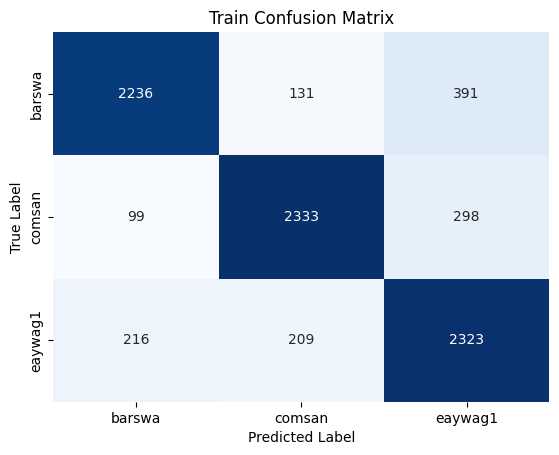

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

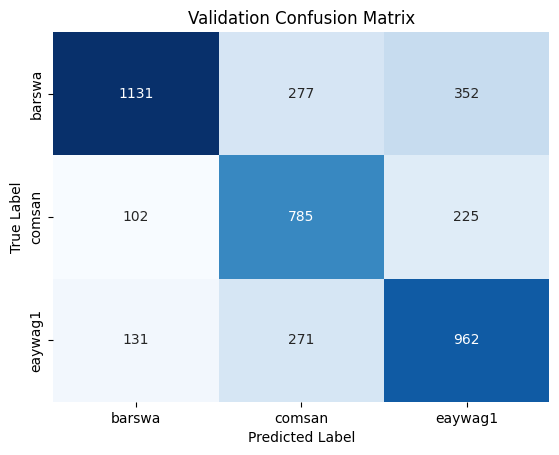

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & chroma

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['chroma'],), axis=1)

training_features

array([[0.6599398 , 0.67788196, 0.5916634 , ..., 0.4059525 , 0.4374207 ,
        0.4954643 ],
       [0.54474825, 0.31021774, 0.40692937, ..., 0.2900794 , 0.45217955,
        0.34645888],
       [0.7466248 , 0.49147087, 0.51950824, ..., 0.39935866, 0.4376189 ,
        0.6003393 ],
       ...,
       [0.6093918 , 0.6710483 , 0.61745954, ..., 0.31887493, 0.31697342,
        0.38165548],
       [0.67268836, 0.6454089 , 0.576661  , ..., 0.6198623 , 0.6679676 ,
        0.7234871 ],
       [0.44762298, 0.71293   , 0.66515446, ..., 0.7246826 , 0.69019556,
        0.674213  ]], dtype=float32)

In [ ]:
training_features.shape

(8236, 32)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['chroma']), axis=1)

validation_features

array([[0.76568013, 0.57164913, 0.46456724, ..., 0.68654543, 0.53037053,
        0.55995166],
       [0.48107755, 0.44918987, 0.60531807, ..., 0.41521764, 0.41251028,
        0.42443395],
       [0.5220496 , 0.42991617, 0.4323247 , ..., 0.38761166, 0.41776043,
        0.38158906],
       ...,
       [0.5756709 , 0.46205077, 0.4850275 , ..., 0.65162444, 0.6062873 ,
        0.5246389 ],
       [0.7267026 , 0.6311999 , 0.46390355, ..., 0.68770427, 0.6747188 ,
        0.6681061 ],
       [0.5396506 , 0.4281005 , 0.3346228 , ..., 0.34563476, 0.37817886,
        0.35873854]], dtype=float32)

In [ ]:
validation_features.shape

(4236, 32)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['mfcc_chroma'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['mfcc_chroma'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.957625060709082
Validation accuracy: 0.6789423984891407


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.96      0.94      0.95      2758
      comsan       0.98      0.96      0.97      2730
     eaywag1       0.94      0.97      0.95      2748

    accuracy                           0.96      8236
   macro avg       0.96      0.96      0.96      8236
weighted avg       0.96      0.96      0.96      8236



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.73      0.66      0.69      1760
      comsan       0.66      0.72      0.69      1112
     eaywag1       0.63      0.66      0.65      1364

    accuracy                           0.68      4236
   macro avg       0.68      0.68      0.68      4236
weighted avg       0.68      0.68      0.68      4236



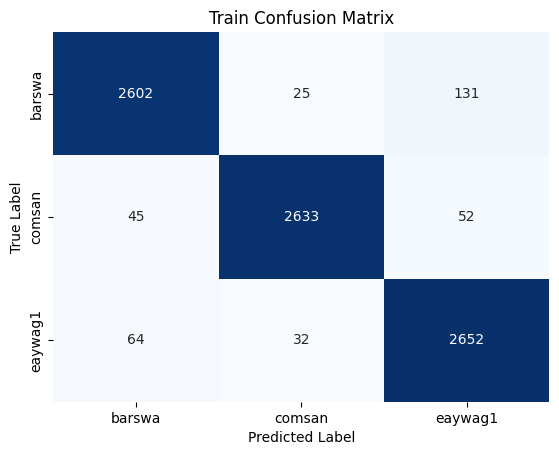

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

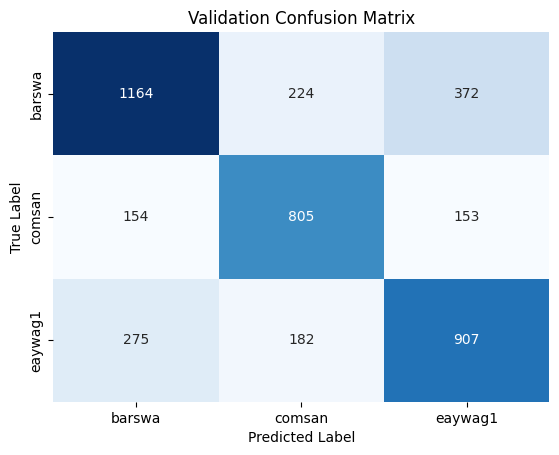

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & chroma & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['chroma'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.65993983, 0.67788196, 0.59166342, ..., 0.        , 1.        ,
        0.        ],
       [0.54474825, 0.31021774, 0.40692937, ..., 0.        , 0.        ,
        0.        ],
       [0.74662483, 0.49147087, 0.51950824, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.60939181, 0.67104828, 0.61745954, ..., 0.        , 1.        ,
        0.        ],
       [0.67268836, 0.64540893, 0.57666099, ..., 0.        , 1.        ,
        0.        ],
       [0.44762298, 0.71293002, 0.66515446, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
training_features.shape

(8236, 37)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['chroma'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.76568013, 0.57164913, 0.46456724, ..., 1.        , 0.        ,
        0.        ],
       [0.48107755, 0.44918987, 0.60531807, ..., 0.        , 0.        ,
        0.        ],
       [0.52204961, 0.42991617, 0.43232471, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.5756709 , 0.46205077, 0.48502749, ..., 0.        , 1.        ,
        0.        ],
       [0.72670257, 0.6311999 , 0.46390355, ..., 0.        , 1.        ,
        0.        ],
       [0.53965062, 0.4281005 , 0.3346228 , ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(4236, 37)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['mfcc_chroma_continents'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['mfcc_chroma_continents'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.8950947061680428
Validation accuracy: 0.7245042492917847


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.92      0.87      0.90      2758
      comsan       0.93      0.91      0.92      2730
     eaywag1       0.85      0.90      0.87      2748

    accuracy                           0.90      8236
   macro avg       0.90      0.90      0.90      8236
weighted avg       0.90      0.90      0.90      8236



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.81      0.71      0.76      1760
      comsan       0.66      0.73      0.69      1112
     eaywag1       0.69      0.73      0.71      1364

    accuracy                           0.72      4236
   macro avg       0.72      0.73      0.72      4236
weighted avg       0.73      0.72      0.73      4236



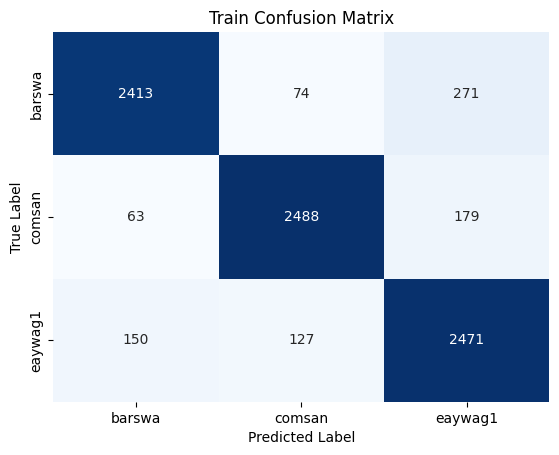

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

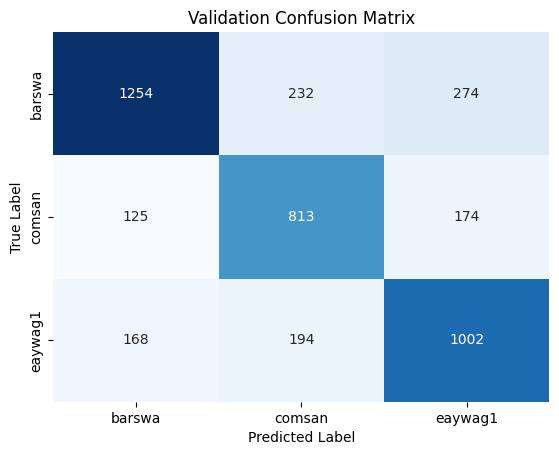

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & rms & spectral_centroid

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['rms'], audio_df['train']['spectral_centroid']), axis=1)

training_features

array([[0.6599398 , 0.67788196, 0.5916634 , ..., 0.5140197 , 0.07944974,
        0.18257274],
       [0.54474825, 0.31021774, 0.40692937, ..., 0.43495765, 0.02735221,
        0.5580287 ],
       [0.7466248 , 0.49147087, 0.51950824, ..., 0.43034962, 0.0467274 ,
        0.5518772 ],
       ...,
       [0.6093918 , 0.6710483 , 0.61745954, ..., 0.4895677 , 0.01671822,
        0.25034085],
       [0.67268836, 0.6454089 , 0.576661  , ..., 0.33752975, 0.01731251,
        0.31776923],
       [0.44762298, 0.71293   , 0.66515446, ..., 0.5489154 , 0.00727899,
        0.15188685]], dtype=float32)

In [ ]:
training_features.shape

(8236, 22)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['rms'], audio_df['val']['spectral_centroid']), axis=1)

validation_features

array([[0.76568013, 0.57164913, 0.46456724, ..., 0.40277624, 0.03714661,
        0.4149493 ],
       [0.48107755, 0.44918987, 0.60531807, ..., 0.46817103, 0.0114965 ,
        0.54003876],
       [0.5220496 , 0.42991617, 0.4323247 , ..., 0.51023674, 0.00733309,
        0.5523133 ],
       ...,
       [0.5756709 , 0.46205077, 0.4850275 , ..., 0.5162465 , 0.03266476,
        0.56785625],
       [0.7267026 , 0.6311999 , 0.46390355, ..., 0.5004192 , 0.02468226,
        0.33517313],
       [0.5396506 , 0.4281005 , 0.3346228 , ..., 0.50845426, 0.01352605,
        0.5132443 ]], dtype=float32)

In [ ]:
validation_features.shape

(4236, 22)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['mfcc_rms_spectral_centroid'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['mfcc_rms_spectral_centroid'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.9253278290432249
Validation accuracy: 0.6815391879131256


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.92      0.92      0.92      2758
      comsan       0.96      0.93      0.94      2730
     eaywag1       0.90      0.92      0.91      2748

    accuracy                           0.93      8236
   macro avg       0.93      0.93      0.93      8236
weighted avg       0.93      0.93      0.93      8236



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.73      0.68      0.70      1760
      comsan       0.64      0.76      0.69      1112
     eaywag1       0.66      0.62      0.64      1364

    accuracy                           0.68      4236
   macro avg       0.68      0.69      0.68      4236
weighted avg       0.68      0.68      0.68      4236



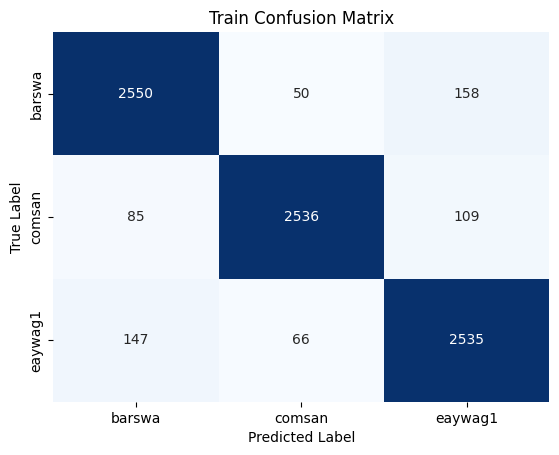

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

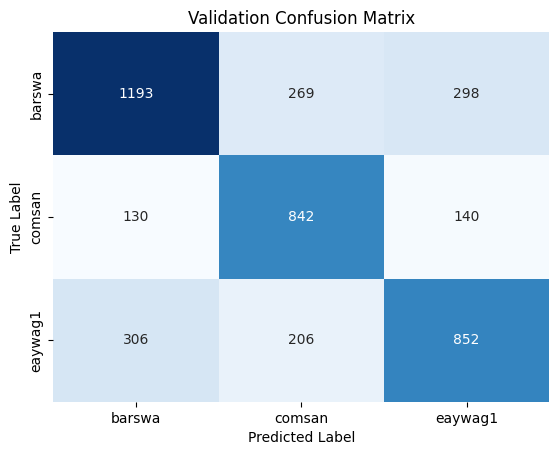

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & rms & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['rms'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.65993983, 0.67788196, 0.59166342, ..., 0.        , 1.        ,
        0.        ],
       [0.54474825, 0.31021774, 0.40692937, ..., 0.        , 0.        ,
        0.        ],
       [0.74662483, 0.49147087, 0.51950824, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.60939181, 0.67104828, 0.61745954, ..., 0.        , 1.        ,
        0.        ],
       [0.67268836, 0.64540893, 0.57666099, ..., 0.        , 1.        ,
        0.        ],
       [0.44762298, 0.71293002, 0.66515446, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
training_features.shape

(8236, 26)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['rms'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.76568013, 0.57164913, 0.46456724, ..., 1.        , 0.        ,
        0.        ],
       [0.48107755, 0.44918987, 0.60531807, ..., 0.        , 0.        ,
        0.        ],
       [0.52204961, 0.42991617, 0.43232471, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.5756709 , 0.46205077, 0.48502749, ..., 0.        , 1.        ,
        0.        ],
       [0.72670257, 0.6311999 , 0.46390355, ..., 0.        , 1.        ,
        0.        ],
       [0.53965062, 0.4281005 , 0.3346228 , ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(4236, 26)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['mfcc_rms_continents'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['mfcc_rms_continents'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.8322000971345314
Validation accuracy: 0.6732766761095373


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.86      0.81      0.84      2758
      comsan       0.88      0.85      0.86      2730
     eaywag1       0.77      0.84      0.80      2748

    accuracy                           0.83      8236
   macro avg       0.84      0.83      0.83      8236
weighted avg       0.84      0.83      0.83      8236



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.82      0.64      0.72      1760
      comsan       0.59      0.70      0.64      1112
     eaywag1       0.61      0.70      0.65      1364

    accuracy                           0.67      4236
   macro avg       0.67      0.68      0.67      4236
weighted avg       0.69      0.67      0.68      4236



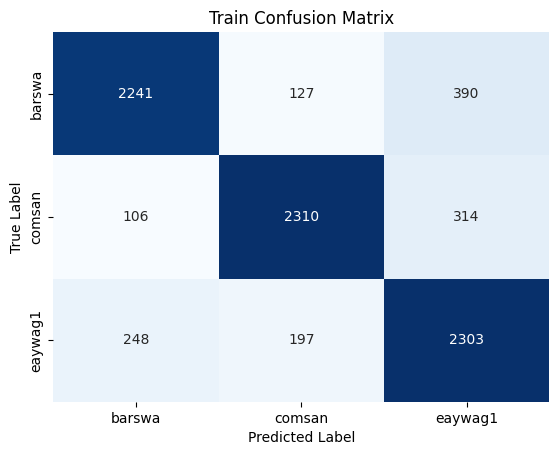

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

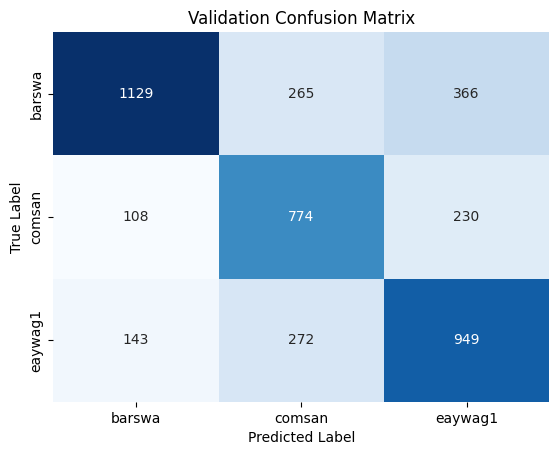

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & spectral_centroid & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['spectral_centroid'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.65993983, 0.67788196, 0.59166342, ..., 0.        , 1.        ,
        0.        ],
       [0.54474825, 0.31021774, 0.40692937, ..., 0.        , 0.        ,
        0.        ],
       [0.74662483, 0.49147087, 0.51950824, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.60939181, 0.67104828, 0.61745954, ..., 0.        , 1.        ,
        0.        ],
       [0.67268836, 0.64540893, 0.57666099, ..., 0.        , 1.        ,
        0.        ],
       [0.44762298, 0.71293002, 0.66515446, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
training_features.shape

(8236, 26)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['spectral_centroid'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.76568013, 0.57164913, 0.46456724, ..., 1.        , 0.        ,
        0.        ],
       [0.48107755, 0.44918987, 0.60531807, ..., 0.        , 0.        ,
        0.        ],
       [0.52204961, 0.42991617, 0.43232471, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.5756709 , 0.46205077, 0.48502749, ..., 0.        , 1.        ,
        0.        ],
       [0.72670257, 0.6311999 , 0.46390355, ..., 0.        , 1.        ,
        0.        ],
       [0.53965062, 0.4281005 , 0.3346228 , ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(4236, 26)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['mfcc_spectral_centroid_continents'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['mfcc_spectral_centroid_continents'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.8493200582807188
Validation accuracy: 0.6916902738432483


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.89      0.83      0.86      2758
      comsan       0.88      0.87      0.88      2730
     eaywag1       0.79      0.85      0.82      2748

    accuracy                           0.85      8236
   macro avg       0.85      0.85      0.85      8236
weighted avg       0.85      0.85      0.85      8236



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.85      0.66      0.74      1760
      comsan       0.59      0.72      0.65      1112
     eaywag1       0.64      0.70      0.67      1364

    accuracy                           0.69      4236
   macro avg       0.69      0.70      0.69      4236
weighted avg       0.71      0.69      0.70      4236



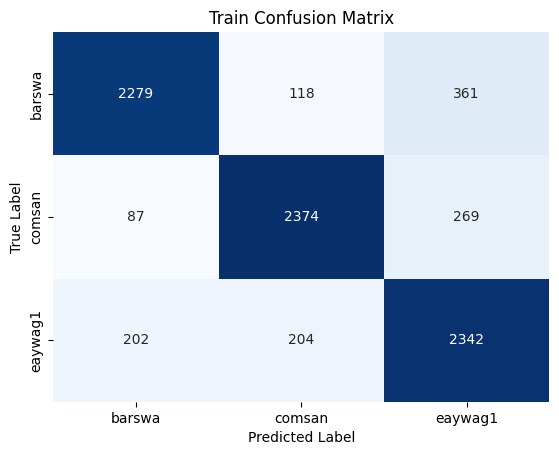

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

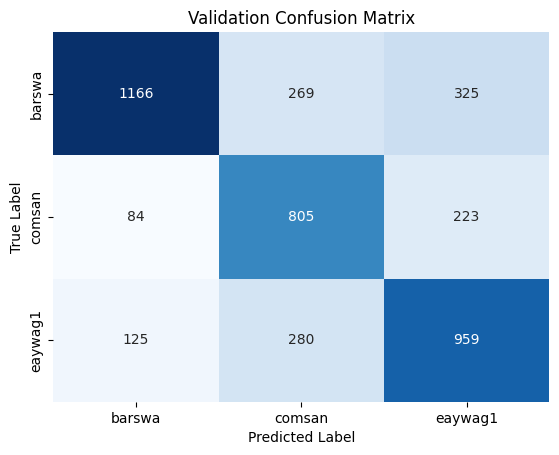

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With melspectrogram & chroma

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['melspectrogram'], audio_df['train']['chroma']), axis=1)

training_features

array([[0.8243726 , 0.67964154, 0.62437314, ..., 0.4059525 , 0.4374207 ,
        0.4954643 ],
       [0.31649908, 0.3279071 , 0.3359106 , ..., 0.2900794 , 0.45217955,
        0.34645888],
       [0.63880485, 0.5984165 , 0.6214866 , ..., 0.39935866, 0.4376189 ,
        0.6003393 ],
       ...,
       [0.70898753, 0.6645553 , 0.6461834 , ..., 0.31887493, 0.31697342,
        0.38165548],
       [0.72381747, 0.7159557 , 0.69224507, ..., 0.6198623 , 0.6679676 ,
        0.7234871 ],
       [0.6733246 , 0.5939276 , 0.50325996, ..., 0.7246826 , 0.69019556,
        0.674213  ]], dtype=float32)

In [ ]:
training_features.shape

(8236, 32)

In [ ]:
validation_features = np.concatenate((audio_df['val']['melspectrogram'], audio_df['val']['chroma']), axis=1)

validation_features

array([[0.64931566, 0.6859798 , 0.7082681 , ..., 0.68654543, 0.53037053,
        0.55995166],
       [0.55238986, 0.41732618, 0.3797185 , ..., 0.41521764, 0.41251028,
        0.42443395],
       [0.5045034 , 0.36111075, 0.26215607, ..., 0.38761166, 0.41776043,
        0.38158906],
       ...,
       [0.4397016 , 0.4179946 , 0.4642485 , ..., 0.65162444, 0.6062873 ,
        0.5246389 ],
       [0.6575653 , 0.6613865 , 0.681567  , ..., 0.68770427, 0.6747188 ,
        0.6681061 ],
       [0.31623325, 0.33782125, 0.35986283, ..., 0.34563476, 0.37817886,
        0.35873854]], dtype=float32)

In [ ]:
validation_features.shape

(4236, 32)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['melspectrogram_chroma'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['melspectrogram_chroma'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.9233851384167071
Validation accuracy: 0.6560434372049103


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.94      0.91      0.92      2758
      comsan       0.96      0.92      0.94      2730
     eaywag1       0.88      0.94      0.91      2748

    accuracy                           0.92      8236
   macro avg       0.93      0.92      0.92      8236
weighted avg       0.93      0.92      0.92      8236



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.74      0.65      0.69      1760
      comsan       0.62      0.68      0.65      1112
     eaywag1       0.59      0.65      0.62      1364

    accuracy                           0.66      4236
   macro avg       0.65      0.66      0.65      4236
weighted avg       0.66      0.66      0.66      4236



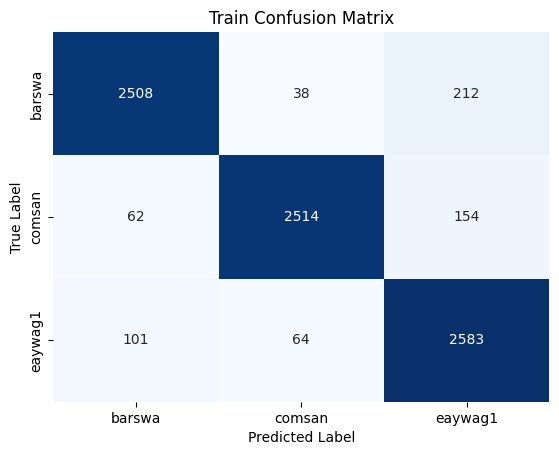

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

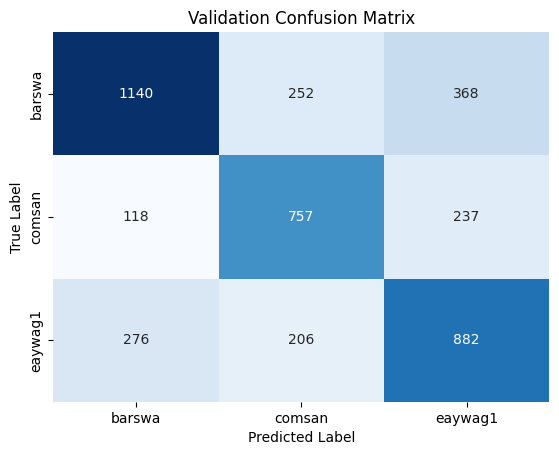

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With melspectrogram & chroma & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['melspectrogram'], audio_df['train']['chroma'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.82437259, 0.67964154, 0.62437314, ..., 0.        , 1.        ,
        0.        ],
       [0.31649908, 0.32790709, 0.33591059, ..., 0.        , 0.        ,
        0.        ],
       [0.63880485, 0.59841651, 0.6214866 , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.70898753, 0.66455531, 0.64618337, ..., 0.        , 1.        ,
        0.        ],
       [0.72381747, 0.71595567, 0.69224507, ..., 0.        , 1.        ,
        0.        ],
       [0.67332458, 0.59392762, 0.50325996, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
training_features.shape

(8236, 37)

In [ ]:
validation_features = np.concatenate((audio_df['val']['melspectrogram'], audio_df['val']['chroma'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.64931566, 0.68597978, 0.70826811, ..., 1.        , 0.        ,
        0.        ],
       [0.55238986, 0.41732618, 0.37971851, ..., 0.        , 0.        ,
        0.        ],
       [0.50450343, 0.36111075, 0.26215607, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.43970159, 0.41799459, 0.46424851, ..., 0.        , 1.        ,
        0.        ],
       [0.6575653 , 0.66138649, 0.68156701, ..., 0.        , 1.        ,
        0.        ],
       [0.31623325, 0.33782125, 0.35986283, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(4236, 37)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['melspectrogram_chroma_continents'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['melspectrogram_chroma_continents'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.8797960174842157
Validation accuracy: 0.6928706326723324


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.92      0.85      0.88      2758
      comsan       0.92      0.88      0.90      2730
     eaywag1       0.81      0.91      0.86      2748

    accuracy                           0.88      8236
   macro avg       0.88      0.88      0.88      8236
weighted avg       0.88      0.88      0.88      8236



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.83      0.65      0.73      1760
      comsan       0.61      0.69      0.65      1112
     eaywag1       0.64      0.75      0.69      1364

    accuracy                           0.69      4236
   macro avg       0.69      0.70      0.69      4236
weighted avg       0.71      0.69      0.70      4236



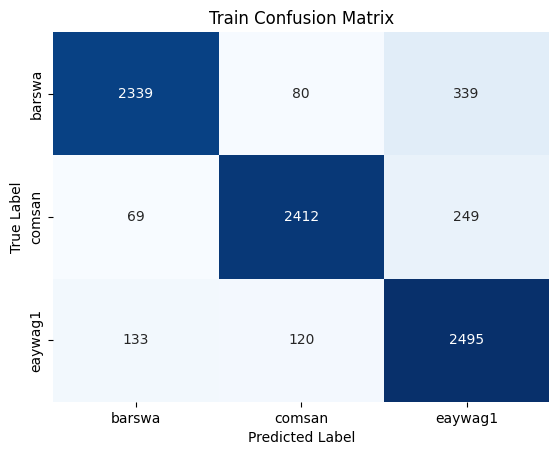

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

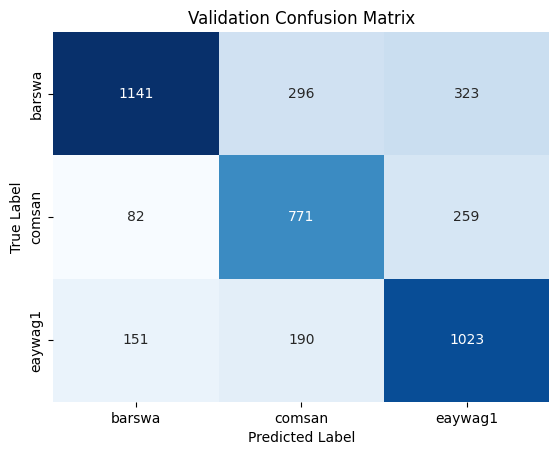

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With melspectrogram & rms & spectral_centroid

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['melspectrogram'], audio_df['train']['rms'], audio_df['train']['spectral_centroid']), axis=1)

training_features

array([[0.8243726 , 0.67964154, 0.62437314, ..., 0.40826425, 0.07944974,
        0.18257274],
       [0.31649908, 0.3279071 , 0.3359106 , ..., 0.481385  , 0.02735221,
        0.5580287 ],
       [0.63880485, 0.5984165 , 0.6214866 , ..., 0.6244075 , 0.0467274 ,
        0.5518772 ],
       ...,
       [0.70898753, 0.6645553 , 0.6461834 , ..., 0.41585457, 0.01671822,
        0.25034085],
       [0.72381747, 0.7159557 , 0.69224507, ..., 0.47216552, 0.01731251,
        0.31776923],
       [0.6733246 , 0.5939276 , 0.50325996, ..., 0.25809813, 0.00727899,
        0.15188685]], dtype=float32)

In [ ]:
training_features.shape

(8236, 22)

In [ ]:
validation_features = np.concatenate((audio_df['val']['melspectrogram'], audio_df['val']['rms'], audio_df['val']['spectral_centroid']), axis=1)

validation_features

array([[0.64931566, 0.6859798 , 0.7082681 , ..., 0.56408864, 0.03714661,
        0.4149493 ],
       [0.55238986, 0.41732618, 0.3797185 , ..., 0.4139909 , 0.0114965 ,
        0.54003876],
       [0.5045034 , 0.36111075, 0.26215607, ..., 0.4568664 , 0.00733309,
        0.5523133 ],
       ...,
       [0.4397016 , 0.4179946 , 0.4642485 , ..., 0.49378058, 0.03266476,
        0.56785625],
       [0.6575653 , 0.6613865 , 0.681567  , ..., 0.4927722 , 0.02468226,
        0.33517313],
       [0.31623325, 0.33782125, 0.35986283, ..., 0.44077992, 0.01352605,
        0.5132443 ]], dtype=float32)

In [ ]:
validation_features.shape

(4236, 22)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['melspectrogram_rms_spectral_centroid'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['melspectrogram_rms_spectral_centroid'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.8380281690140845
Validation accuracy: 0.5691690273843248


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.86      0.85      0.86      2758
      comsan       0.88      0.83      0.86      2730
     eaywag1       0.78      0.83      0.80      2748

    accuracy                           0.84      8236
   macro avg       0.84      0.84      0.84      8236
weighted avg       0.84      0.84      0.84      8236



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.69      0.60      0.64      1760
      comsan       0.53      0.58      0.55      1112
     eaywag1       0.48      0.52      0.50      1364

    accuracy                           0.57      4236
   macro avg       0.57      0.57      0.56      4236
weighted avg       0.58      0.57      0.57      4236



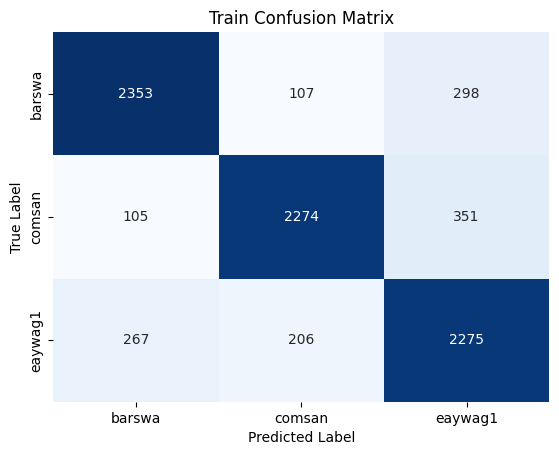

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

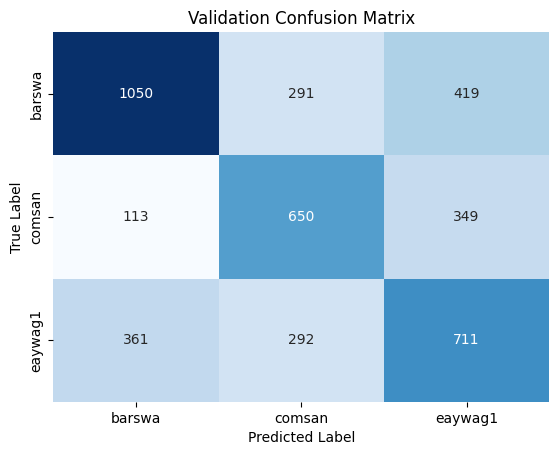

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With melspectrogram & rms & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['melspectrogram'], audio_df['train']['rms'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.82437259, 0.67964154, 0.62437314, ..., 0.        , 1.        ,
        0.        ],
       [0.31649908, 0.32790709, 0.33591059, ..., 0.        , 0.        ,
        0.        ],
       [0.63880485, 0.59841651, 0.6214866 , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.70898753, 0.66455531, 0.64618337, ..., 0.        , 1.        ,
        0.        ],
       [0.72381747, 0.71595567, 0.69224507, ..., 0.        , 1.        ,
        0.        ],
       [0.67332458, 0.59392762, 0.50325996, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
training_features.shape

(8236, 26)

In [ ]:
validation_features = np.concatenate((audio_df['val']['melspectrogram'], audio_df['val']['rms'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.64931566, 0.68597978, 0.70826811, ..., 1.        , 0.        ,
        0.        ],
       [0.55238986, 0.41732618, 0.37971851, ..., 0.        , 0.        ,
        0.        ],
       [0.50450343, 0.36111075, 0.26215607, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.43970159, 0.41799459, 0.46424851, ..., 0.        , 1.        ,
        0.        ],
       [0.6575653 , 0.66138649, 0.68156701, ..., 0.        , 1.        ,
        0.        ],
       [0.31623325, 0.33782125, 0.35986283, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(4236, 26)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['melspectrogram_rms_continents'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['melspectrogram_rms_continents'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.7929820301117048
Validation accuracy: 0.6182719546742209


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.88      0.76      0.81      2758
      comsan       0.83      0.82      0.82      2730
     eaywag1       0.70      0.80      0.75      2748

    accuracy                           0.79      8236
   macro avg       0.80      0.79      0.79      8236
weighted avg       0.80      0.79      0.79      8236



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.82      0.57      0.67      1760
      comsan       0.57      0.62      0.60      1112
     eaywag1       0.52      0.68      0.59      1364

    accuracy                           0.62      4236
   macro avg       0.63      0.62      0.62      4236
weighted avg       0.66      0.62      0.62      4236



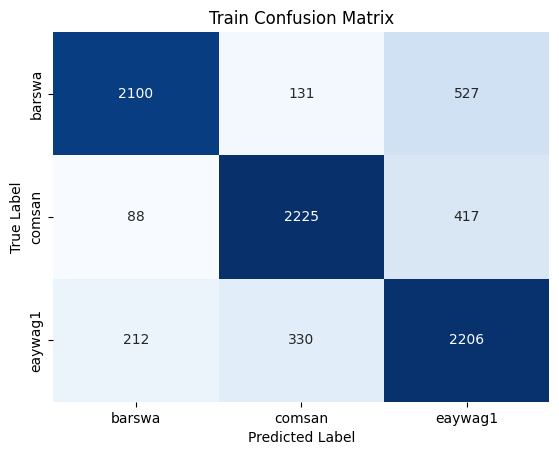

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

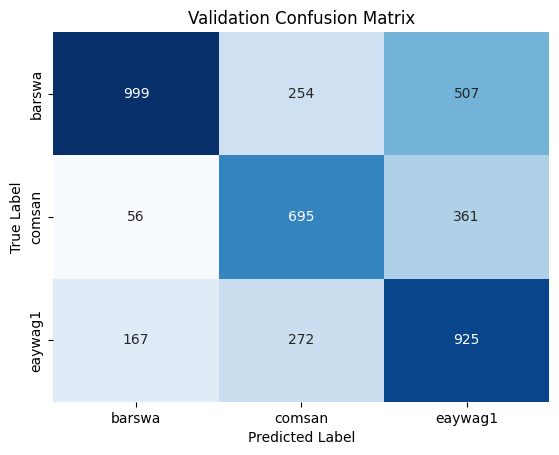

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With melspectrogram & spectral_centroid & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['melspectrogram'], audio_df['train']['spectral_centroid'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.82437259, 0.67964154, 0.62437314, ..., 0.        , 1.        ,
        0.        ],
       [0.31649908, 0.32790709, 0.33591059, ..., 0.        , 0.        ,
        0.        ],
       [0.63880485, 0.59841651, 0.6214866 , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.70898753, 0.66455531, 0.64618337, ..., 0.        , 1.        ,
        0.        ],
       [0.72381747, 0.71595567, 0.69224507, ..., 0.        , 1.        ,
        0.        ],
       [0.67332458, 0.59392762, 0.50325996, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
training_features.shape

(8236, 26)

In [ ]:
validation_features = np.concatenate((audio_df['val']['melspectrogram'], audio_df['val']['spectral_centroid'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.64931566, 0.68597978, 0.70826811, ..., 1.        , 0.        ,
        0.        ],
       [0.55238986, 0.41732618, 0.37971851, ..., 0.        , 0.        ,
        0.        ],
       [0.50450343, 0.36111075, 0.26215607, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.43970159, 0.41799459, 0.46424851, ..., 0.        , 1.        ,
        0.        ],
       [0.6575653 , 0.66138649, 0.68156701, ..., 0.        , 1.        ,
        0.        ],
       [0.31623325, 0.33782125, 0.35986283, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(4236, 26)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['melspectrogram_spectral_centroid_continents'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['melspectrogram_spectral_centroid_continents'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.8040310830500242
Validation accuracy: 0.6177998111425873


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.88      0.77      0.83      2758
      comsan       0.84      0.82      0.83      2730
     eaywag1       0.71      0.82      0.76      2748

    accuracy                           0.80      8236
   macro avg       0.81      0.80      0.81      8236
weighted avg       0.81      0.80      0.81      8236



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.81      0.58      0.67      1760
      comsan       0.56      0.61      0.59      1112
     eaywag1       0.52      0.67      0.59      1364

    accuracy                           0.62      4236
   macro avg       0.63      0.62      0.62      4236
weighted avg       0.65      0.62      0.62      4236



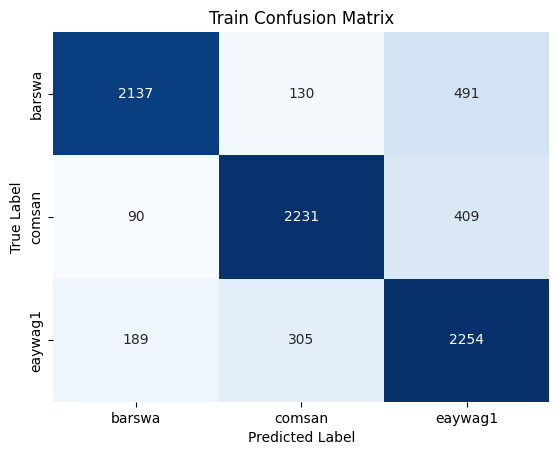

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

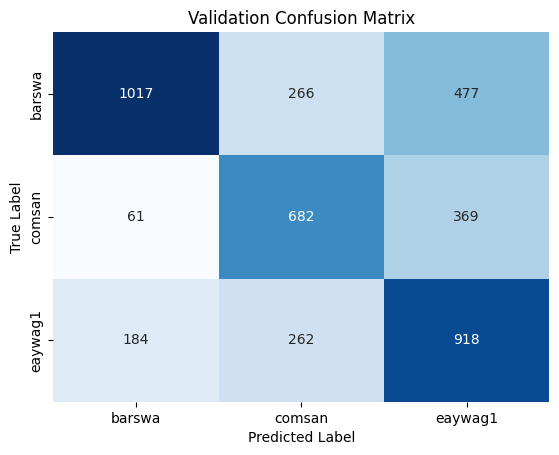

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

# Review results from all models

In [ ]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(2)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(2)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Val_Accuracy')
result_df

,Features,Train_Accuracy,Val_Accuracy
3,rms_spectral_centroid,0.47,0.38
2,chroma,0.71,0.52
13,melspectrogram_rms_spectral_centroid,0.84,0.57
4,melspectrogram,0.86,0.58
14,melspectrogram_rms_continents,0.79,0.62
15,melspectrogram_spectral_centroid_continents,0.80,0.62
1,mfcc,0.96,0.65
11,melspectrogram_chroma,0.92,0.66
9,mfcc_rms_continents,0.83,0.67
5,mfcc_continents,0.84,0.68
